# AI Safety via Debate: MNIST Experiment

In the [original paper](https://arxiv.org/abs/1805.00899) on debate, the authors describe an experiment that they performed:

> Metaphorically, debate targets the situation where the agents see the big picture, but the judge cannot. We can model this by replacing the metaphorical big picture with an actual picture, chosen at random from a distribution. If the image is simple enough, we can do away with natural language entirely: the two agents state their claimed image class up front, then reveal one pixel of the image per turn to the judge. They cannot lie about these pixels, but a dishonest player could choose them adversarially to fool the judge. The game ends after a fixed number of turns, then the judge sees a sparse mask of the revealed pixels and decides which agent’s class is correct.

<img src="https://openai.com/content/images/2018/05/debate-game-flow-figure@2x.png"/>

To start with, we will create the weak-classifier judge.

In [1]:
from platform import python_version
print('Using Python', python_version())

from typing import List, Tuple, Callable
import random
from itertools import cycle

import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

from mcts import Node as MCTSNode, MCTS

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using Python 3.5.4


Using TensorFlow backend.


## Data Generation

In [2]:
def normalise(x: np.ndarray) -> np.ndarray:
    x = x - np.min(x)
    x = x / np.max(x)
    return x

class DataGenerator(keras.utils.Sequence):
    '''
        DataGenerator adapted from 
        https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    '''
    
    def __init__(self, 
                 data: np.ndarray or List[np.ndarray], 
                 labels: np.ndarray, 
                 batch_size=32, 
                 dim=(28, 28), 
                 n_channels=1,
                 n_classes=10, 
                 shuffle=True, 
                 seed=None):
        'Initialization'
        
        if seed is not None:
            np.random.seed(seed)
        
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.labels = to_categorical(labels, 
                                     num_classes=self.n_classes)
        self.data = np.array([
                normalise(sample) 
                for sample in data
        ])
        
        num_samples, *_ = self.data.shape
        self.indices = np.arange(num_samples)
        self.idx_iterator = cycle(range(0, len(self)))
        
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indices after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __len__(self) -> int:
        'Denotes the number of batches per epoch'
        return int(np.floor(self.indices.size / self.batch_size))

    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        'Generate one batch of data'
        # Generate indexes of the batch
        i = index*self.batch_size
        j = (index + 1)*self.batch_size
        indices = self.indices[i:j]

        # Generate data
        X = self.data[indices]
        y = self.labels[indices]

        return X, y
    
    def __next__(self):
        return self[next(self.idx_iterator)]

In [3]:
class MaskedDataGenerator(DataGenerator):
    '''
        DataGenerator that randomly masks generated samples such that only
        a few non-zero elements are preserved.
    '''
    
    def __init__(self,
                 data: np.ndarray or List[np.ndarray], 
                 labels: np.ndarray, 
                 num_preserved=6, 
                 **kwargs):
        super(MaskedDataGenerator, self).__init__(data, labels, **kwargs)
        self.num_preserved = num_preserved
    
    @staticmethod
    def _create_mask(img: np.ndarray, 
                     num_preserved: int) -> np.ndarray:
        non_zero_elements = np.argwhere(img)
        num_non_zero, *_ = non_zero_elements.shape
        sample_indices = np.random.choice(np.arange(num_non_zero), 
                                          size=num_preserved)
        sample = non_zero_elements[sample_indices]
        mask = np.zeros(img.shape)
        mask[sample[:, 0], sample[:, 1]] = 1
        return mask
    
    def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
        X, y = super(MaskedDataGenerator, self).__getitem__(index)
        masks = np.array([
                self._create_mask(img, self.num_preserved)
                for img in X
        ])
        return X*masks, y

In [4]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

A sampling of the generated data is shown below with the original images in light blue and the brighter pixels showing what is revealled after the masking.

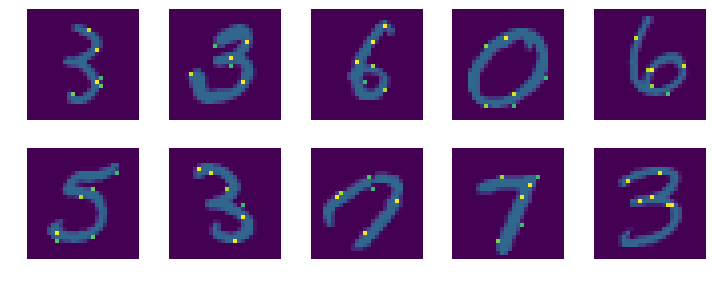

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
mnist_train_data_gen = DataGenerator(X_train, y_train, seed=0)
for row in axs:
    for ax in row:
        (img, *_), y = next(mnist_train_data_gen)
        mask = MaskedDataGenerator._create_mask(img, 6)
        ax.imshow(img*0.5 + mask)
        ax.axis('off')
plt.tight_layout()
plt.show()

## Judge Model Definition

In [6]:
def judge_untrained():
    inputs = keras.Input(shape=(28, 28, 1))

    output = Convolution2D(32, (3, 3), activation='relu')(inputs)
    output = Convolution2D(32, (3, 3), activation='relu')(output)
    output = MaxPooling2D(pool_size=(2,2))(output)
    output = Dropout(0.25)(output)

    output = Flatten()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(10, activation='softmax')(output)
    
    model = keras.Model(inputs=[inputs], outputs=[output])   
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

judge_untrained().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
__________

## Training the Judge

Firstly, we will do a sanity check and train a judge on unmasked data to verify that it learns to perform well.

In [155]:
judge = judge_untrained()
train_data_gen = DataGenerator(X_train.reshape(X_train.shape + (1,)), 
                               y_train, seed=0)
val_data_gen = DataGenerator(X_test.reshape(X_test.shape + (1,)), 
                             y_test)
judge.fit_generator(train_data_gen, validation_data=val_data_gen)

Epoch 1/1
1875/1875 [==============================] - 67s 36ms/step - loss: 0.2086 - acc: 0.9361 - val_loss: 0.0498 - val_acc: 0.9848


We can see that it achieves an accuracy score of 98.3% on the test data.

Now, when we train it on the masked data (only 6 pixels shown), we can see that it performs significantly worse with a test accuracy of 50.5%. A number that is comparable to the results in the paper (section 3, table 2).

In [156]:
judge = judge_untrained()
train_data_gen = MaskedDataGenerator(X_train.reshape(X_train.shape + (1,)), 
                                     y_train, seed=0)
val_data_gen = MaskedDataGenerator(X_test.reshape(X_test.shape + (1,)), 
                                   y_test)
judge.fit_generator(train_data_gen, validation_data=val_data_gen);

Epoch 1/1
1875/1875 [==============================] - 45s 24ms/step - loss: 1.5829 - acc: 0.4470 - val_loss: 1.4138 - val_acc: 0.5116


## Monte-Carlo Tree Search

Debate is framed as a zero-sum two-player game, and while this formulation is indepedent of any particular player implementation, the authors note that an approach that has worked well for similar problems is Monte-Carlo Tree Search (MCTS). I am adapting [Luke Harold Miles' minimal implementation of MCTS](https://gist.github.com/qpwo/c538c6f73727e254fdc7fab81024f6e1) for the debate game.

In [41]:
class PixelDebatePlayer(object):
    
    def __init__(self,
                 precommit: int or None,
                 is_honest: bool):
        """
        A participant in the debate game
        params:
        - precommit: Determines the win criteria for the player. If it is a number then the 
            player wins only if the judge comes to the conclusion of the precommit.
            It can only be None if the player is not honest, and in this situation the
            player wins only if the honest player succeeds in convincing the judge.
        - is_honest: An indicator of honesty
        """
        self.precommit = precommit
        self.is_honest = is_honest
        self.tree = PixelDebateMCTS()
        

class PixelDebateGame(object):
    
    def __init__(self,
                 image: np.ndarray,
                 judge: Callable[[np.ndarray], int],
                 player_1: PixelDebatePlayer,
                 player_2: PixelDebatePlayer,
                 game_length=6,
                 rollouts_per_move=10000,
                 seed=0):
        """
        Game information
        params:
        - image: the image that the debaters are picking pixels from
        - judge: A function that takes and image and determines the MNIST class
        - player_1: The player that goes first
        - player_2: The player that goes second
        - game_length: The number of turns in the game
        - rollouts_per_move: Number of MCTS simulations per move
        """
        self.image = image
        self.judge = judge
        self.player_1 = player_1
        self.player_2 = player_2
        self.game_length = game_length
        self.rollouts_per_move = rollouts_per_move
        random.seed(seed)
        
    def other_player(self, player: PixelDebatePlayer) -> PixelDebatePlayer:
        return self.player_1 if player == self.player_2 else self.player_2
        
    def masked_image(self, moves_played: List[Tuple[int, int]]) -> np.ndarray:
        """
        Creates mask from moves played and applies it to the input image
        params:
        - moves_played: List of coordinates that have been played so far
        """
        indices = np.array(moves_played)
        xs, ys = indices[:, 0], indices[:, 1]
        img = np.zeros(self.image.shape)
        img[xs, ys] = self.image[xs, ys]
        return img
    
    def judge_verdict(self, moves_played: List[Tuple[int, int]]) -> np.ndarray:
        """
        Returns the judges verdict on the game
        params:
        - moves_played: List of coordinates that have been played so far
        """
        return self.judge(self.masked_image(moves_played))
    
    def winner(self, moves_played: List[Tuple[int, int]]) -> PixelDebatePlayer:
        
        verdict = self.judge_verdict(moves_played)
        
        for player in [self.player_1, self.player_2]:
            if verdict == player.precommit or (
                player.precommit is None and 
                verdict != self.other_player(player).precommit
            ):
                return player
        
        return None
        
    def play(self) -> List[Tuple[int, int]]:
        """
        Plays a game and returns the moves that were made
        """
        moves_played = []
        current_player = self.player_1
        
        for _ in range(6):
            state = PixelDebateMCTSNode(
                game=self,
                searcher=current_player,
                moves_played=moves_played
            )
            
            for _ in range(self.rollouts_per_move):
                current_player.tree.do_rollout(state)
                
            next_state = current_player.tree.choose(state)
            moves_played = next_state.moves_played
            current_player = state.adversary
        
        return moves_played

    
class PixelDebateMCTSNode(MCTSNode):
    
    def __init__(self,
                 game: PixelDebateGame,
                 searcher: PixelDebatePlayer,
                 current_player: PixelDebatePlayer=None,
                 moves_played: List[Tuple[int, int]] = []):
        """
        A state of play in the debate game
        params:
        - game: Description of the current game
        - searcher: The player who is performing the search
        - current_player: The player whose turn it is to make a move 
        - moves_played: List of coordinates that have been played so far
        """
        self.game = game
        self.searcher = searcher
        self.adversary = game.other_player(searcher)
        self.current_player = current_player or searcher
        self.moves_played = moves_played

    def find_children(self):
        "All possible successors of this board state"
        
        next_player = self.game.other_player(self.current_player)
        
        return {
            PixelDebateMCTSNode(self.game,
                                self.searcher,
                                next_player,
                                self.moves_played + [tuple(coord),])
            for coord in np.argwhere(self.game.image)
            if tuple(coord) not in self.moves_played
        }

    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        if self.is_terminal():
            return None
        return random.choice(list(self.find_children()))

    def is_terminal(self) -> bool:
        "Returns True if the node has no children"
        return len(self.moves_played) >= self.game.game_length 

    def reward(self) -> float:
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        winner = self.game.winner(self.moves_played)
        if winner == self.searcher:
            return 1
        if winner == self.adversary:
            return 0
        return 0.5

    def __hash__(self):
        "Nodes must be hashable"
        # sorting to ensure that the state is the same regardless
        coords = sorted(self.moves_played)
        return hash(str(coords))

    def __eq__(node1, node2):
        "Nodes must be comparable"
        return set(node1.moves_played) == set(node2.moves_played) \
            and node1.game == node2.game
    

class PixelDebateMCTS(MCTS):
    
    def _select_decendent(self, node: PixelDebateMCTSNode) -> PixelDebateMCTSNode:
        """
        The debate paper outlines how their selection is atypical but
        follows from AlphaZero (Silver et al., 2016).
        Details on page 26 of: 
        https://discovery.ucl.ac.uk/id/eprint/10045895/1/agz_unformatted_nature.pdf
        """
        
        def U(n: PixelDebateMCTSNode) -> float:
            P = 1.0 / np.sum(n.game.image > 0)
            child_visits = sum([
                self.N[c] for c in self.children.get(n, [])
            ])
            return P * np.sqrt(child_visits) / (self.N[n] + 1)
        
        def puct(n: PixelDebateMCTSNode) -> float:
            return self.Q[n] + U(n)
        
        return max(self.children[node], key=puct)

In [168]:
.argmax()

3

In [185]:
data_gen = DataGenerator(X_train, 
                         y_train, 
                         seed=0)
(img, *_), (y, *__) = next(data_gen)
y = np.argmax(y)

honest_player = PixelDebatePlayer(precommit=y, is_honest=True)

not_y = random.choice([i for i in range(1, 11) if i != y])
lying_player = PixelDebatePlayer(precommit=not_y, is_honest=False)

def judge_fn(img):
    x = img.reshape(img.shape + (1,))
    x = np.array([x])
    return judge.predict(x).argmax()

game = PixelDebateGame(image=img, 
                       judge=judge_fn, 
                       player_1=honest_player, 
                       player_2=lying_player,
                       rollouts_per_move=50,
                       seed=0)

In [186]:
moves = game.play()
if game.winner(moves) == honest_player:
    print('The honest player wins!')
elif game.winner(moves) == lying_player:
    print('The lying player wins!')
else:
    print('It was a draw.')

It was a draw.


### Visualising the Moves

Here we display the image that the game was played with alongside the moves that were made.
Blue pixels indicate moves made by the honest player and red by the lying player.

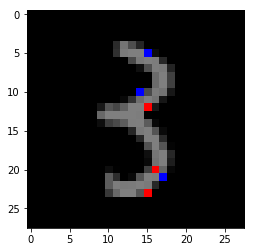

In [187]:
res = np.repeat(0.5*img, 3).reshape(img.shape + (3,))

p1_idx = np.array([moves[0], moves[2], moves[4]])
res[p1_idx[:, 0], p1_idx[:, 1], :] = 0
res[p1_idx[:, 0], p1_idx[:, 1], 2] = 1

p2_idx = np.array([moves[1], moves[3], moves[5]])
res[p2_idx[:, 0], p2_idx[:, 1], :] = 0
res[p2_idx[:, 0], p2_idx[:, 1], 0] = 1

plt.imshow(res);